# Hyperparameter combinations

In [80]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

metric = 'auc_relaxed'

dataset = 'kws'
base_path = f'/home/ec2-user/evaluations/{dataset}'

if metric == 'auc':
    value = 'roc_auc'
    intersection = '0.05'
if metric == 'leo_metric':
    value = 'leo_metric'
    intersection = '0'
if metric == 'auc_relaxed':
    value = 'roc_auc'
    intersection = '0.09'

In [81]:
import itertools

files_auc = [
    f'{base_path}/{metric}_SHAP_p{{}}_w{{}}_f{{}}_m{{}}_{intersection}.tsv',
    f'{base_path}/{metric}_LR_p{{}}_w{{}}_f{{}}_m{{}}_{intersection}.tsv',
    f'{base_path}/{metric}_RF_p{{}}_w{{}}_f{{}}_m{{}}_{intersection}.tsv',
]


ps = [0.2, 0.3, 0.4]
ws = [1, 3, 5]
fs = ['euclidean']
ms = ['zeros', 'noise']
methods = ['SHAP', 'LR', 'RF']
dfs = []
for method, file_template in zip(methods, files_auc):
    for p, w, f, m in itertools.product(ps, ws, fs, ms):
        file_path = file_template.format(p, w, f, m)
        try:
            df = pd.read_csv(file_path, sep='\t')
            df['method'] = method
            df['mask_percentage'] = p
            df['window_size'] = w
            df['distance_function'] = f
            df['masking_strategy'] = m
            dfs.append(df)
        except FileNotFoundError:
            print(f"File not found: {file_path}")

final_df = pd.concat(dfs, ignore_index=True)
mean_auc_df = final_df.groupby(['method', 'mask_percentage', 'masking_strategy', 'window_size'])[value].mean().reset_index()

In [82]:
files_auc_complete = [
    f'{base_path}/{metric}_SHAP_{{}}_{intersection}.tsv',
    f'{base_path}/{metric}_LR_{{}}_{intersection}.tsv',
    f'{base_path}/{metric}_RF_{{}}_{intersection}.tsv',
]

names = ["zeros", 'noise']
methods = ['SHAP', 'LR', 'RF']

df_combinations = []
for method, file_template in zip(methods, files_auc_complete):
    for name in names:
        file_path = file_template.format(name)
        try:
            df_combination = pd.read_csv(file_path, sep='\t')
            df_combination['method'] = method
            df_combination['name'] = name
            df_combinations.append(df_combination)
        except FileNotFoundError:
            print(f"File not found: {file_path}")
            
final_df_combination = pd.concat(df_combinations, ignore_index=True)


In [83]:
mean_auc_df_combination =final_df_combination.groupby(['method', 'name'])[value].mean().reset_index()

/tmp/ipykernel_277207/443981797.py:35: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot=pivot_table.applymap(lambda x: f"{x:.2f}".lstrip('0')),
/tmp/ipykernel_277207/443981797.py:35: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot=pivot_table.applymap(lambda x: f"{x:.2f}".lstrip('0')),
/tmp/ipykernel_277207/443981797.py:35: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot=pivot_table.applymap(lambda x: f"{x:.2f}".lstrip('0')),


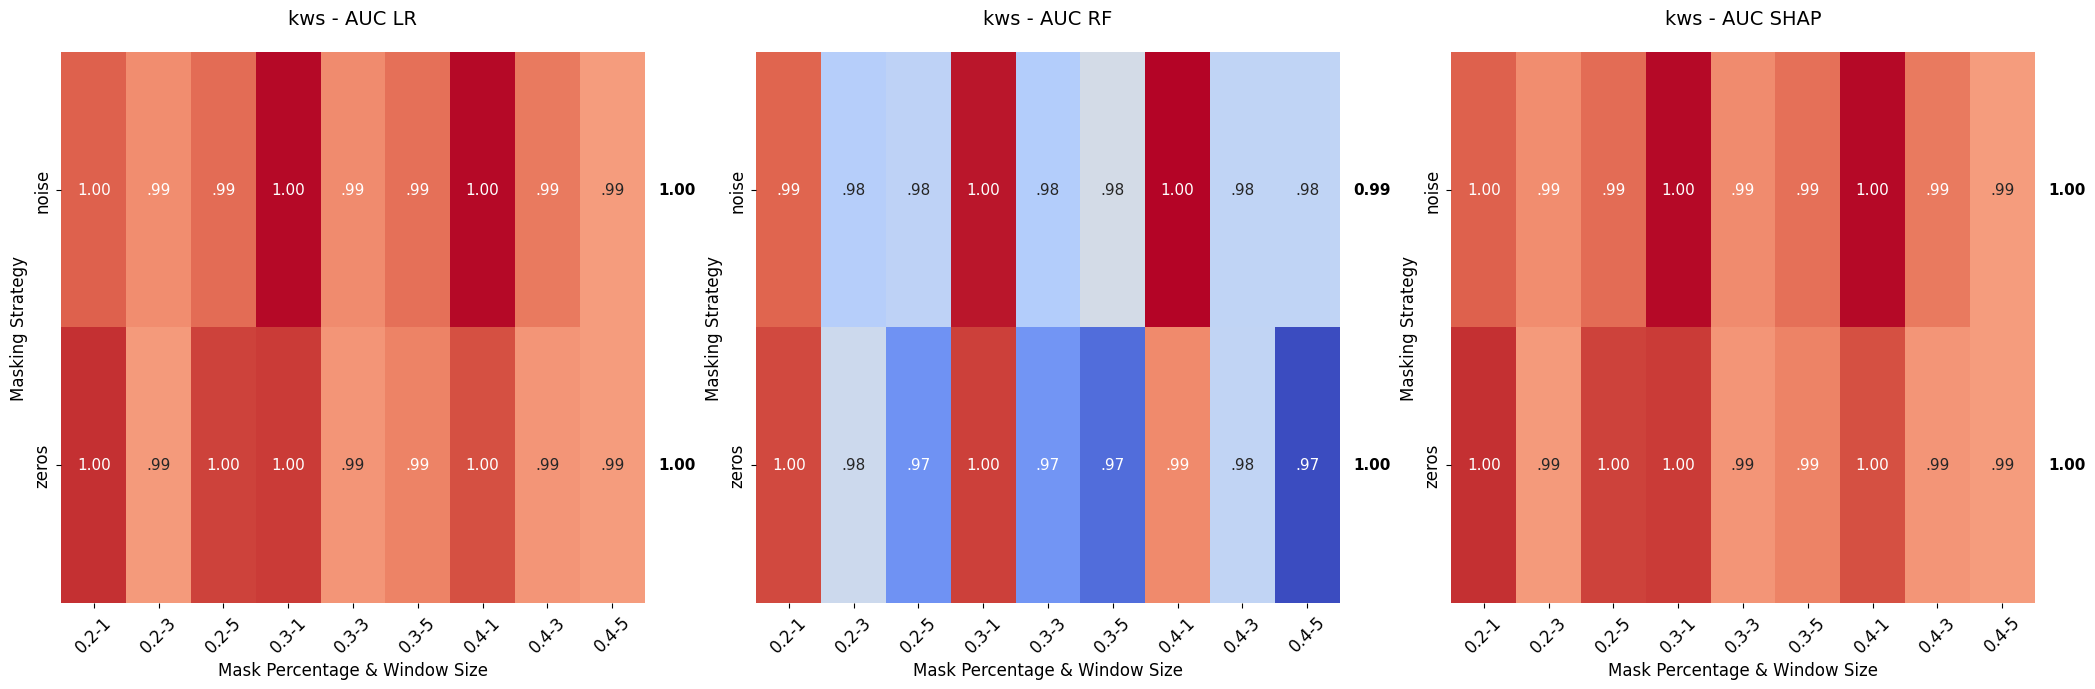

In [84]:
TITLE_SIZE = 14
LABEL_SIZE = 12
ANNOT_SIZE = 11
TICK_SIZE = 12

max_auc = mean_auc_df[value].max()
min_auc = mean_auc_df[value].min()

methods = mean_auc_df['method'].unique()
n_methods = len(methods)
n_cols = 3  
n_rows =1
fig, axes = plt.subplots(n_rows, n_cols, figsize=(7*n_cols, 7*n_rows))
axes = axes.flatten()  # Flatten axes array for easier iteration
if n_methods < len(axes):
    for idx in range(n_methods, len(axes)):
        axes[idx].set_visible(False)

for idx, method in enumerate(methods):
    ax = axes[idx]

    # Create pivot table for current method
    pivot_table = mean_auc_df[mean_auc_df['method'] == method].pivot(
        index='masking_strategy', 
        columns=['mask_percentage', 'window_size'], 
        values=value
    )

    annotations = mean_auc_df_combination[mean_auc_df_combination['method'] == method].set_index('name')[value]
    row_labels = pivot_table.index
    row_annotations = [annotations.get(label, '') for label in row_labels]  # Get roc_auc or empty string

    sns.heatmap(
        pivot_table,
        annot=pivot_table.applymap(lambda x: f"{x:.2f}".lstrip('0')),
        cmap="coolwarm",
        fmt="",
        ax=ax,
        vmin=min_auc,
        vmax=max_auc,
        cbar=(idx == n_methods),
        annot_kws={'size': ANNOT_SIZE}
    )
    ax.set_title(f'{dataset} - AUC {method}', fontsize=TITLE_SIZE, pad=20)
    ax.set_xlabel('Mask Percentage & Window Size', fontsize=LABEL_SIZE)
    ax.set_ylabel('Masking Strategy', fontsize=LABEL_SIZE)

    # Set tick label sizes
    ax.tick_params(axis='both', which='major', labelsize=TICK_SIZE)
    ax.tick_params(axis='x', rotation=45)
    # if idx == n_methods-1:
    #     cbar = plt.colorbar(ax.collections[0], ax=ax, fraction=0.02, pad=0.04)
    #     cbar.ax.tick_params(labelsize=4)
    for i, valu in enumerate(row_annotations):
        ax.text(pivot_table.shape[1] + 0.5, i + 0.5, f"{valu:.2f}" if valu else "", 
                ha='center', va='center', fontsize=ANNOT_SIZE, color='black', fontweight='bold')
plt.tight_layout()
plt.show()


In [85]:
import ast
from utils import clean_and_eval

metric = 'score_curve'
methods = ['SHAP', 'LR', 'RF']

base_path = f'/home/ec2-user/evaluations/{dataset}'

files_auc_complete = [
    f'{base_path}/{metric}_SHAP_{{}}.tsv',
    f'{base_path}/{metric}_LR_{{}}.tsv',
    f'{base_path}/{metric}_RF_{{}}.tsv',
]

names=['zeros', 'noise']
metric = 'score_curve'

df_combinations = []
for method, file_template in zip(methods, files_auc_complete):
    for name in names:
        file_path = file_template.format(name)
        try:
            df_combination = pd.read_csv(file_path, sep='\t')
            df_combination['method'] = method
            df_combination['name'] = name
            if dataset == "drums":
                df_combination['log_odds'] = df_combination['actual_score'].apply(clean_and_eval)
            else:
                df_combination['log_odds'] = df_combination['actual_score'].apply(ast.literal_eval)

            df_combination['log_odds_curve'] = df_combination['score_curve_sacando_topk'].apply(ast.literal_eval)
            df_combination['event_label'] = df_combination['event_label'].apply(int)
            percentages = [0.01, 0.05, 0.1, 0.2, 0.5]
            for i in percentages:
                df_combination[f'top_{i}'] = df_combination.apply(
                    lambda row: row['log_odds'][row['event_label']] - row['log_odds_curve'][int(len(row['log_odds_curve']) * i)][row['event_label']],
                    axis=1
                )

        except FileNotFoundError:
            print(f"File not found: {file_path}")

        df_combinations.append(df_combination)
            
final_df_combination_ff = pd.concat(df_combinations, ignore_index=True)

In [86]:
mean_auc_df_combination_ff = final_df_combination_ff.groupby(['method', 'name'])[['top_0.01', 'top_0.05', 'top_0.1', 'top_0.2', 'top_0.5']].mean().reset_index()
mean_auc_df_combination_ff

,method,name,top_0.01,top_0.05,top_0.1,top_0.2,top_0.5
0,LR,noise,4.587467,10.482407,14.081780,17.103657,15.025367
1,LR,zeros,7.807562,13.807992,18.565279,24.542711,34.042566
2,RF,noise,4.135195,6.951430,6.601155,3.298838,-1.768223
3,RF,zeros,7.820766,13.531373,17.501106,22.834563,30.135040
4,SHAP,noise,5.019496,10.181631,13.466872,16.559167,12.507384
5,SHAP,zeros,7.878345,14.282667,18.876162,24.697723,33.210172


In [87]:
from scipy.stats import pearsonr

corr1, _ = pearsonr(mean_auc_df_combination['roc_auc'], mean_auc_df_combination_ff['top_0.01'])
corr5, _ = pearsonr(mean_auc_df_combination['roc_auc'], mean_auc_df_combination_ff['top_0.05'])
corr10, _ = pearsonr(mean_auc_df_combination['roc_auc'], mean_auc_df_combination_ff['top_0.1'])
corr20, _ = pearsonr(mean_auc_df_combination['roc_auc'], mean_auc_df_combination_ff['top_0.2'])
corr50, _ = pearsonr(mean_auc_df_combination['roc_auc'], mean_auc_df_combination_ff['top_0.5'])

print(f'Correlation for dataset {dataset}')
print(f'Correlation 1% {corr1}')
print(f'Correlation 5% {corr5}')
print(f'Correlation 10% {corr10}')
print(f'Correlation 20% {corr20}')
print(f'Correlation 50% {corr50}')

Correlation for dataset kws
Correlation 1% 0.30951303664150837
Correlation 5% 0.5800552600031061
Correlation 10% 0.6989989683127416
Correlation 20% 0.7369409836950219
Correlation 50% 0.5508919604897003


## Prepare videos

In here we will create a video to look at the result, we need to select the instances to plot. In this case, we decided to filter by FF 20% as its the number that correlates more. And in that case 

In [88]:
final_df_combination_ff.groupby(["method", "name"], as_index=False).apply(lambda x: x.sort_values("top_0.2", ascending=True)).loc[2]


/tmp/ipykernel_277207/1817889981.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  final_df_combination_ff.groupby(["method", "name"], as_index=False).apply(lambda x: x.sort_values("top_0.2", ascending=True)).loc[2]


,filename,event_label,actual_score,score_curve_sacando_topk,method,name,log_odds,log_odds_curve,top_0.01,top_0.05,top_0.1,top_0.2,top_0.5
298,5142-36377-0014.flac,0,[6.6862335205078125],"[[6.994778156280518], [7.741024017333984], [8....",RF,noise,[6.6862335205078125],"[[6.994778156280518], [7.741024017333984], [8....",-1.364994,-2.391977,-5.888847,-8.286657,-10.523609
250,121-127105-0024.flac,0,[1.8380283117294312],"[[-0.45023012161254883], [0.4915480613708496],...",RF,noise,[1.8380283117294312],"[[-0.45023012161254883], [0.4915480613708496],...",1.346480,-1.601901,0.036507,-6.571702,-12.915571
281,1188-133604-0009.flac,0,[3.328657627105713],"[[2.2433292865753174], [3.2585463523864746], [...",RF,noise,[3.328657627105713],"[[2.2433292865753174], [3.2585463523864746], [...",1.789831,-2.845897,-3.169819,-5.967327,-10.379442
291,3575-170457-0046.flac,0,[2.840980052947998],"[[0.03114812821149826], [-0.16920523345470428]...",RF,noise,[2.840980052947998],"[[0.03114812821149826], [-0.16920523345470428]...",3.574948,2.862409,-0.099557,-5.448066,-10.976881
297,672-122797-0002.flac,0,[1.0219147205352783],"[[-0.6803560853004456], [0.09082702547311783],...",RF,noise,[1.0219147205352783],"[[-0.6803560853004456], [0.09082702547311783],...",0.931088,6.783110,-1.224893,-4.902041,-16.081071
269,4970-29095-0007.flac,0,[0.3222081661224365],"[[-1.334410548210144], [-5.790915012359619], [...",RF,noise,[0.3222081661224365],"[[-1.334410548210144], [-5.790915012359619], [...",6.113123,6.568296,3.096400,-4.681505,-15.090376
253,1995-1826-0026.flac,0,[3.4760777950286865],"[[0.16940699517726898], [-0.6063393950462341],...",RF,noise,[3.4760777950286865],"[[0.16940699517726898], [-0.6063393950462341],...",4.082417,4.221171,2.328482,-4.655039,-13.019686
296,1221-135766-0011.flac,0,[11.236153602600098],"[[9.623332977294922], [7.568469524383545], [8....",RF,noise,[11.236153602600098],"[[9.623332977294922], [7.568469524383545], [8....",3.667684,-0.390108,-2.836878,-4.365386,-7.017396
275,4992-41806-0014.flac,0,[8.74367618560791],"[[5.180444717407227], [5.52485466003418], [3.4...",RF,noise,[8.74367618560791],"[[5.180444717407227], [5.52485466003418], [3.4...",3.218822,5.357209,4.892881,-2.979930,-11.640712
263,4992-41797-0018.flac,0,[1.6726971864700317],"[[-2.0222392082214355], [0.19919829070568085],...",RF,noise,[1.6726971864700317],"[[-2.0222392082214355], [0.19919829070568085],...",3.694936,5.916752,5.356275,-2.692200,-10.044524


In [99]:
final_df_combination[final_df_combination["filename"] == "5683-32865-0017.flac"]

,filename,event_label,actual_score,real_order,model_order,roc_auc,true_markers,method,name
11,5683-32865-0017.flac,0.0,20.254063,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,[ 0.06682753 -0.12234866 -0.58978893 -1.152397...,1.0,"[[3.15, 3.38]]",SHAP,zeros
61,5683-32865-0017.flac,0.0,20.254063,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,[ 0.61058632 0.33239575 -0.25120577 0.330749...,1.0,"[[3.15, 3.38]]",SHAP,noise
111,5683-32865-0017.flac,0.0,20.254063,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,[ 2.04813512e+00 1.32214604e+00 4.72761996e-...,1.0,"[[3.15, 3.38]]",LR,zeros
161,5683-32865-0017.flac,0.0,20.254063,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,[ 0.27550335 -0.09116115 -0.47761496 0.148492...,1.0,"[[3.15, 3.38]]",LR,noise
211,5683-32865-0017.flac,0.0,20.254063,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,[0.00305414 0.0041146 0.00403469 0.00327468 0...,1.0,"[[3.15, 3.38]]",RF,zeros
261,5683-32865-0017.flac,0.0,20.254063,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,[0.00241509 0.00264854 0.00306295 0.00410415 0...,1.0,"[[3.15, 3.38]]",RF,noise


In [101]:
from utils import create_visualization
import librosa

waveform, sr = librosa.load("/home/ec2-user/mnt/data/LibriSpeech24K/test-clean/5683/32865/5683-32865-0017.flac", sr=16000)
json_file = f"/home/ec2-user/results/explanations_kws/5683-32865-0017.flac/kws/ft_0_zeros.json"
output_file = "/home/ec2-user/explain_where/plots/kws/5683-32865-0017.flac-zeros.mp4"

create_visualization(waveform, json_file, output_file)


/home/ec2-user/explain_where/utils.py:233: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  ax.plot(time_points, values, 'k-', linewidth=1, color='black')


Saving temporary video...
Combining video and audio...
Final video with audio saved as /home/ec2-user/explain_where/plots/kws/5683-32865-0017.flac-zeros.mp4


ffmpeg version 7.1 Copyright (c) 2000-2024 the FFmpeg developers
  built with gcc 13.3.0 (conda-forge gcc 13.3.0-1)
  configuration: --prefix=/opt/conda --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1735646943276/_build_env/bin/x86_64-conda-linux-gnu-cc --cxx=/home/conda/feedstock_root/build_artifacts/ffmpeg_1735646943276/_build_env/bin/x86_64-conda-linux-gnu-c++ --nm=/home/conda/feedstock_root/build_artifacts/ffmpeg_1735646943276/_build_env/bin/x86_64-conda-linux-gnu-nm --ar=/home/conda/feedstock_root/build_artifacts/ffmpeg_1735646943276/_build_env/bin/x86_64-conda-linux-gnu-ar --disable-doc --enable-openssl --enable-demuxer=dash --enable-hardcoded-tables --enable-libfreetype --enable-libharfbuzz --enable-libfontconfig --enable-libopenh264 --enable-libdav1d --disable-gnutls --enable-libmp3lame --enable-libvpx --enable-libass --enable-pthreads --enable-vaapi --enable-libopenvino --enable-gpl --enable-libx264 --enable-libx265 --enable-libaom --enable-libsvtav1 --enable-libxml2 

# Drums test

In [40]:
base_path = f'/home/ec2-user/evaluations/drums'
metric = 'order'
names = ["zeros", "noise"]
methods = ['kernel_shap_sumcons', 'linear_regression_noreg_noweights', 'tree_importance']

files_auc_complete = [
    f'{base_path}/{metric}_kernel_shap_sumcons_{{}}_{{}}.tsv',
    f'{base_path}/{metric}_linear_regression_noreg_noweights_{{}}_{{}}.tsv',
    f'{base_path}/{metric}_tree_importance_{{}}_{{}}.tsv',
]
names = ["zeros", "noise"]

df_combinations = []
for method, file_template in zip(methods, files_auc_complete):
    for i in [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45]:
        for name in names:
            file_path = file_template.format(name, i)
            try:
                df_combination = pd.read_csv(file_path, sep='\t')
                if method == 'tree_importance':
                    df_combination['method'] = 'RF'
                if method == 'linear_regression_noreg_noweights':
                    df_combination['method'] = 'LR'
                if method == 'kernel_shap_sumcons':
                    df_combination['method'] = 'SHAP'
                df_combination['name'] = name
                df_combination['final'] = i
                df_combinations.append(df_combination)
            except FileNotFoundError:
                print(f"File not found: {file_path}")
                
final_df_combination = pd.concat(df_combinations, ignore_index=True)


In [56]:
final_df_combination['group'] = final_df_combination['method'] + '-' + \
                    final_df_combination['name'].astype(str)
final_df_combination = final_df_combination[final_df_combination['final'] != 0.1]

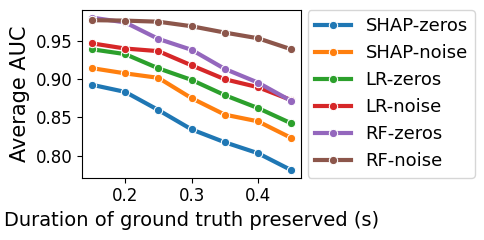

In [83]:
plt.figure(figsize=(5, 2.5))  # Hacemos el gráfico más compacto
sns.lineplot(data=final_df_combination, 
            x="final", 
            y="roc_auc", 
            hue="group", 
            marker="o",
            errorbar=None,
            linewidth=3)  # Líneas más gruesas

# Labels y título con fuentes grandes
plt.xlabel("Duration of ground truth preserved (s)", fontsize=14)
plt.ylabel("Average AUC", fontsize=15)

# Leyenda afuera y a lo largo
plt.legend(bbox_to_anchor=(1.03, 1), 
          loc='upper left', 
          borderaxespad=0.,
          fontsize=13)

plt.tick_params(axis='both', labelsize=12)  # Números de los ejes más grandes

# Ajustar los márgenes para que la leyenda no se corte
plt.tight_layout()

# Guardar en formato PDF sin márgenes adicionales
plt.savefig("drums_curves.pdf", format='pdf', bbox_inches='tight')

plt.show()

